# Penny Crack inverse problem (3DT0)

This example involves a 2d circular crack, or a 'penny crack' in an infinite, isotropic medium. We use a triangular element with one collocation point to solve for the crack.

We supply the following traction boundary conditions to the solver,
$$
t(x) =
    \begin{cases}
        \sigma_A & \text{if } x \leq |r|\\
        0 & \text{if } x > |r|
    \end{cases}
$$

And the following displacement solution is obtained,
$$
D(x) = {8 (1-\nu^2) \sigma_A \over \pi E} \sqrt{r^2 - x^2}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres

import sys
import os

from matplotlib import ticker, cm, colors

np.set_printoptions(precision=5, suppress=True)

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.rcParams['font.size'] = 12
#plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
#plt.rcParams["text.latex.preamble"] =r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

from pathlib import Path
basefolder = "./data/"
Path(basefolder).mkdir(parents=True, exist_ok=True)

home = os.environ['HOME'] 
# sys.path.append(home + "/geolab/dev_bigwham/build/interfaces/python")
# from bigwham4py import Hmatrix  # linear operator file

sys.path.append(home + "/Desktop/GEL/BigWham/build/interfaces/python")
from hmatrix import Hmatrix  # linear operator file

In [2]:
dim = 3

radius = 1.0 #length
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

max_leaf_size = 16
eta = 3.0
eps_aca = 1e-3

In [3]:
h_array = [0.5,0.25,0.1,0.05,0.025,0.01]
rel_error_array = []

for h in h_array:
    coord = np.load("data/mesh_coords_%s.npy"%(h))
    conn = np.load("data/mesh_conn_%s.npy"%(h))

    # Create H-matrix
    kernel = "3DT0"
    hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)
    col_pts = hmat.getMeshCollocationPoints()

    trac = np.zeros(col_pts.shape)
    trac[:, 2] = pressure
    #print(trac)

    u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
    dd_calc = hmat.convert_to_global(u)
    #print(dd_calc)

    pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)
    dd = np.zeros(col_pts.shape)
    dd[:, 2] = pre_fac * np.sqrt(
        radius * radius - np.linalg.norm(col_pts[:, :2], axis=1) ** 2
    )

    rel_err = np.linalg.norm(dd_calc - dd.flatten()) / dd_calc.shape[0]
    print("L2 Rel error {}".format(rel_err))
    rel_error_array.append(rel_err)

L2 Rel error 0.0034682794701249454
 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  4.081e-06
Binary cluster tree depth = 2
Number of blocks = 16
Number of full blocks = 16
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 16 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 3
Creation of hmat done in 0.00242771
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.001, eta = 3
BigWhamIO ENDED
 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  5.7744e-05
Binary cluster tree depth = 4
Number of blocks = 127
Number of full blocks = 69
Number of low rank blocks = 58
Pattern Created 
 Loop on full blocks construction  
 N full blocks 69 
Loop on low rank blocks construction
N low rank blocks 58
dof_dimension: 3
C

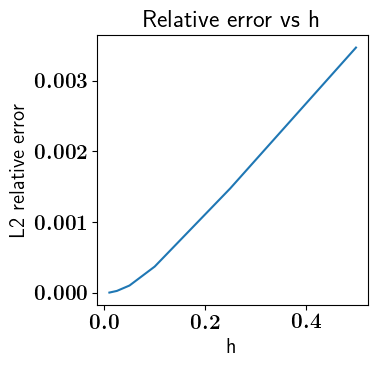

In [4]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

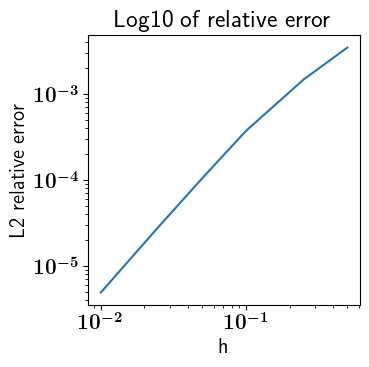

In [5]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Log10 of relative error")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [10]:
print(h_array)
print(rel_error_array)

[0.5, 0.25, 0.1, 0.05, 0.025, 0.01]
[0.0034682794701249454, 0.0014765228557227432, 0.0003722518133502053, 0.00010478885744032248, 2.8534336925811935e-05, 4.915362674197312e-06]


In [9]:
log_h = np.log(np.asarray(h_array)[2:])
log_rel_array = np.log(np.asarray(rel_error_array)[2:])

m, c = np.polyfit(log_h, log_rel_array, 1)

print(m)
print(c)

1.8804477703550506
-3.5468285766875693


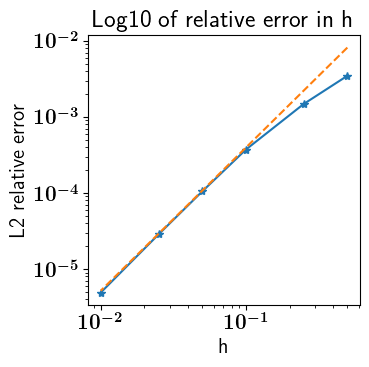

In [11]:
plt.figure()
plt.plot(h_array, rel_error_array, "*-")
plt.plot(h_array, 0.03 * np.array(h_array) ** m , "--")
plt.title("Log10 of relative error in h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log',base=10)
plt.xscale('log',base=10)

In [12]:
h_array = [0.5,0.25,0.1,0.05,0.025,0.01]
rel_error_array = []

for h in h_array:
    coord = np.load("data/mesh_coords_%s.npy"%(h))
    conn = np.load("data/mesh_conn_%s.npy"%(h))

    # Create H-matrix
    kernel = "3DT0"
    hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)
    col_pts = hmat.getMeshCollocationPoints()

    trac = np.zeros(col_pts.shape)
    trac[:, 2] = pressure
    #print(trac)

    u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
    dd_calc = hmat.convert_to_global(u)
    #print(dd_calc)

    pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)
    dd = np.zeros(col_pts.shape)
    dd[:, 2] = pre_fac * np.sqrt(radius * radius - np.linalg.norm(col_pts[:, :2], axis=1)**2
    )

    rel_err = np.linalg.norm(dd_calc - dd.flatten()) / dd.shape[0]
    print("L2 Rel error {}".format(rel_err))
    rel_error_array.append(rel_err)

 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  4.77e-06
Binary cluster tree depth = 2
Number of blocks = 16
Number of full blocks = 16
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 16 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 3
Creation of hmat done in 0.00083434
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.001, eta = 3
BigWhamIO ENDED
L2 Rel error 0.0104048384103748
 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  4.2891e-05
Binary cluster tree depth = 4
Number of blocks = 127
Number of full blocks = 69
Number of low rank blocks = 58
Pattern Created 
 Loop on full blocks construction  
 N full blocks 69 
Loop on low rank blocks construction
N low rank blocks 58
dof_dimension: 3
Creat

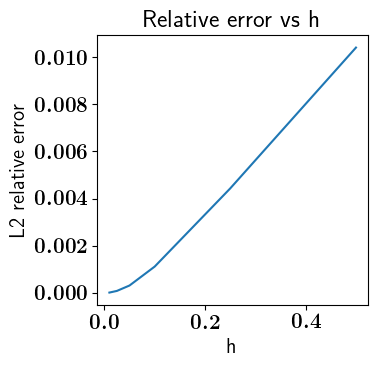

In [13]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

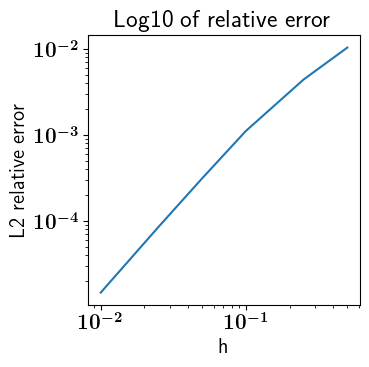

In [14]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Log10 of relative error")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [15]:
print(h_array)
print(rel_error_array)

[0.5, 0.25, 0.1, 0.05, 0.025, 0.01]
[0.0104048384103748, 0.004429568567168213, 0.0011167554400506165, 0.0003143665723209641, 8.56030107774364e-05, 1.4746088022591968e-05]


In [16]:
log_h = np.log(np.asarray(h_array)[2:])
log_rel_array = np.log(np.asarray(rel_error_array)[2:])

m, c = np.polyfit(log_h, log_rel_array, 1)

print(m)
print(c)

1.8804477703550484
-2.448216288019468


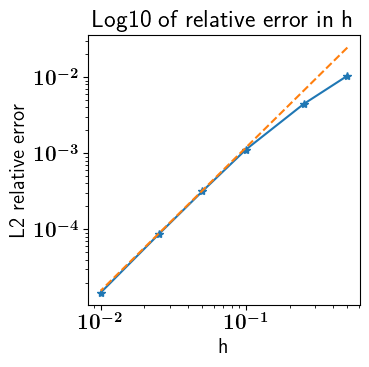

In [17]:
plt.figure()
plt.plot(h_array, rel_error_array, "*-")
plt.plot(h_array, 0.09 * np.array(h_array) ** m , "--")
plt.title("Log10 of relative error in h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log',base=10)
plt.xscale('log',base=10)

In [18]:
h_array = [0.5,0.25,0.1,0.05,0.025,0.01]
rel_error_array = []

for h in h_array:
    coord = np.load("data/mesh_coords_%s.npy"%(h))
    conn = np.load("data/mesh_conn_%s.npy"%(h))

    # Create H-matrix
    kernel = "3DT0"
    hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)
    col_pts = hmat.getMeshCollocationPoints()

    trac = np.zeros(col_pts.shape)
    trac[:, 2] = pressure
    #print(trac)

    u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
    dd_calc = hmat.convert_to_global(u)
    #print(dd_calc)

    pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)
    dd = np.zeros(col_pts.shape)
    dd[:, 2] = pre_fac * np.sqrt(radius * radius - np.linalg.norm(col_pts[:, :2], axis=1)**2
    )

    rel_err = np.linalg.norm(dd_calc - dd.flatten()) / pre_fac
    print("L2 Rel error {}".format(rel_err))
    rel_error_array.append(rel_err)

 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  5.421e-06
Binary cluster tree depth = 2
Number of blocks = 16
Number of full blocks = 16
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 16 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 3
Creation of hmat done in 0.000779665
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.001, eta = 3
BigWhamIO ENDED
L2 Rel error 0.44673277346157236
 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  4.3965e-05
Binary cluster tree depth = 4
Number of blocks = 127
Number of full blocks = 69
Number of low rank blocks = 58
Pattern Created 
 Loop on full blocks construction  
 N full blocks 69 
Loop on low rank blocks construction
N low rank blocks 58
dof_dimension: 3
Cr

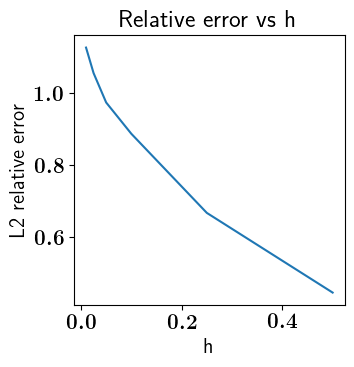

In [19]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

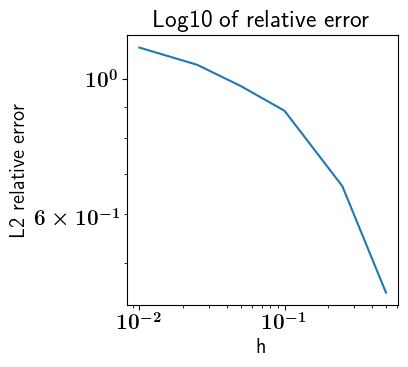

In [21]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Log10 of relative error")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()